<a href="https://colab.research.google.com/github/abhisheksuran/Atari_DQN/blob/master/A2C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf 
import gym
import tensorflow_probability as tfp
import tensorflow.keras.losses as kls

In [ ]:

!pip3 install box2d-py

     |████████████████████████████████| 450kB 4.8MB/s 


In [ ]:
env= gym.make("CartPole-v0")
low = env.observation_space.low
high = env.observation_space.high

In [ ]:
class critic(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.d1 = tf.keras.layers.Dense(128,activation='relu')
    #self.d2 = tf.keras.layers.Dense(32,activation='relu')
    self.v = tf.keras.layers.Dense(1, activation = None)

  def call(self, input_data):
    x = self.d1(input_data)
    #x = self.d2(x)
    v = self.v(x)
    return v
    

class actor(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.d1 = tf.keras.layers.Dense(128,activation='relu')
    #self.d2 = tf.keras.layers.Dense(32,activation='relu')
    self.a = tf.keras.layers.Dense(2,activation='softmax')

  def call(self, input_data):
    x = self.d1(input_data)
    #x = self.d2(x)
    a = self.a(x)
    return a

In [ ]:
class agent():
    def __init__(self, gamma = 0.99):
        self.gamma = gamma
        self.a_opt = tf.keras.optimizers.RMSprop(learning_rate=7e-3)
        self.c_opt = tf.keras.optimizers.RMSprop(learning_rate=7e-3)
        self.actor = actor()
        self.critic = critic()

          
    def act(self,state):
        prob = self.actor(np.array([state]))
        prob = prob.numpy()
        dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32)
        action = dist.sample()
        return int(action.numpy()[0])
  


    def actor_loss(self, probs, actions, td):
        
        probability = []
        log_probability= []
        for pb,a in zip(probs,actions):
          dist = tfp.distributions.Categorical(probs=pb, dtype=tf.float32)
          log_prob = dist.log_prob(a)
          prob = dist.prob(a)
          probability.append(prob)
          log_probability.append(log_prob)

        # print(probability)
        # print(log_probability)

        p_loss= []
        e_loss = []
        td = td.numpy()
        #print(td)
        for pb, t, lpb in zip(probability, td, log_probability):
                        t =  tf.constant(t)
                        policy_loss = tf.math.multiply(lpb,t)
                        entropy_loss = tf.math.negative(tf.math.multiply(pb,lpb))
                        p_loss.append(policy_loss)
                        e_loss.append(entropy_loss)
        p_loss = tf.stack(p_loss)
        e_loss = tf.stack(e_loss)
        p_loss = tf.reduce_mean(p_loss)
        e_loss = tf.reduce_mean(e_loss)
        # print(p_loss)
        # print(e_loss)
        loss = -p_loss - 0.0001 * e_loss
        #print(loss)
        return loss

    def learn(self, states, actions, discnt_rewards):
        discnt_rewards = tf.reshape(discnt_rewards, (len(discnt_rewards),))
        
        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
            p = self.actor(states, training=True)
            v =  self.critic(states,training=True)
            v = tf.reshape(v, (len(v),))
            td = tf.math.subtract(discnt_rewards, v)
            # print(discnt_rewards)
            # print(v)
            #print(td.numpy())
            a_loss = self.actor_loss(p, actions, td)
            c_loss = 0.5*kls.mean_squared_error(discnt_rewards, v)
        grads1 = tape1.gradient(a_loss, self.actor.trainable_variables)
        grads2 = tape2.gradient(c_loss, self.critic.trainable_variables)
        self.a_opt.apply_gradients(zip(grads1, self.actor.trainable_variables))
        self.c_opt.apply_gradients(zip(grads2, self.critic.trainable_variables))
        return a_loss, c_loss

In [ ]:
def preprocess1(states, actions, rewards, gamma):
    discnt_rewards = []
    sum_reward = 0
    rewards.reverse()
    for r in rewards:
      sum_reward = r + gamma*sum_reward
      discnt_rewards.append(sum_reward)
    discnt_rewards.reverse()
    states = np.array(states, dtype=np.float32)
    actions = np.array(actions, dtype=np.int32)
    discnt_rewards = np.array(discnt_rewards, dtype=np.float32)

    return states, actions, discnt_rewards

tf.random.set_seed(336699)
agentoo7 = agent()
steps = 250
ep_reward = []
total_avgr = []
for s in range(steps):
  
  done = False
  state = env.reset()
  total_reward = 0
  all_aloss = []
  all_closs = []
  rewards = []
  states = []
  actions = []
  
  while not done:
  
    action = agentoo7.act(state)
    next_state, reward, done, _ = env.step(action)
    rewards.append(reward)
    states.append(state)
    #actions.append(tf.one_hot(action, 2, dtype=tf.int32).numpy().tolist())
    actions.append(action)
    state = next_state
    total_reward += reward
    
    if done:
        ep_reward.append(total_reward)
        avg_reward = np.mean(ep_reward[-100:])
        total_avgr.append(avg_reward)
        print("total reward after {} steps is {} and avg reward is {}".format(s, total_reward, avg_reward))
        states, actions, discnt_rewards = preprocess1(states, actions, rewards, 1)
  
        al,cl = agentoo7.learn(states, actions, discnt_rewards) 
        print(f"al{al}") 
        print(f"cl{cl}")      
      


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

total reward after 0 steps is 24.0 and avg reward is 24.0
al8.580991744995117
cl101.52865600585938
total reward after 1 steps is 18.0 and avg reward is 21.0
al6.569655418395996
cl54.59226989746094
total reward after 2 steps is 30.0 and avg reward is 24.0
al10.033202171325684
cl147.477294921875
total reward after 3 steps is 11.0 and avg reward is 20.75
al3.4086062908172607
cl18.402528762817383
total reward after 4 steps is 16.0 and avg reward is 19.8
al5.239793300628662
cl38.403438568115234
total reward 

In [ ]:
import matplotlib.pyplot as plt

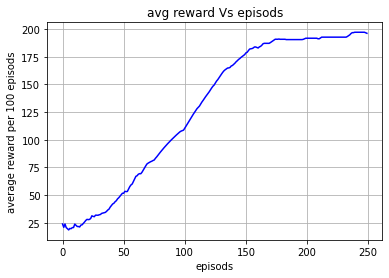

In [ ]:
ep = [i  for i in range(250)]
plt.plot(ep,total_avgr,'b')
plt.title("avg reward Vs episods")
plt.xlabel("episods")
plt.ylabel("average reward per 100 episods")
plt.grid(True)
plt.show()


